In [11]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import os
from jupyterthemes import jtplot
from datetime import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

ROOT_DIR = '..'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
SRC_DIR = os.path.join(ROOT_DIR, 'src')

SEATTLE_CALENDAR = os.path.join(DATA_DIR, 'seattle', 'calendar.csv')
SEATTLE_LISTINGS = os.path.join(DATA_DIR, 'seattle', 'listings.csv')
SEATTLE_REVIEWS = os.path.join(DATA_DIR, 'seattle', 'reviews.csv')

import sys
sys.path.append(SRC_DIR)

In [2]:
calendar = pd.read_csv(SEATTLE_CALENDAR)
listings = pd.read_csv(SEATTLE_LISTINGS)
reviews = pd.read_csv(SEATTLE_REVIEWS)

In [3]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [4]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [5]:
listings.shape

(3818, 92)

In [6]:
num_listings = listings.select_dtypes(include=['int', 'float'])
num_listings.shape

(3818, 30)

In [7]:
num_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 30 columns):
id                                3818 non-null int64
scrape_id                         3818 non-null int64
host_id                           3818 non-null int64
host_listings_count               3816 non-null float64
host_total_listings_count         3816 non-null float64
latitude                          3818 non-null float64
longitude                         3818 non-null float64
accommodates                      3818 non-null int64
bathrooms                         3802 non-null float64
bedrooms                          3812 non-null float64
beds                              3817 non-null float64
square_feet                       97 non-null float64
guests_included                   3818 non-null int64
minimum_nights                    3818 non-null int64
maximum_nights                    3818 non-null int64
availability_30                   3818 non-null int64
availability_60

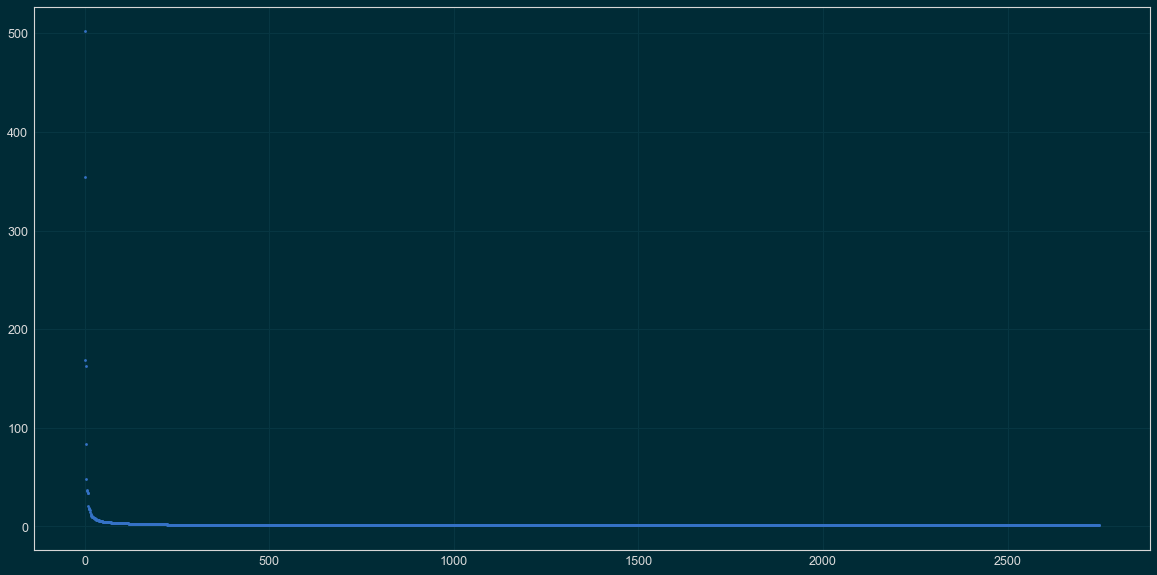

In [17]:
max_listings_per_host = listings.groupby(
    'host_id')['host_listings_count'].max().sort_values(ascending=False)
max_listings_per_host.plot(style='.', use_index=False)

In [18]:
(max_listings_per_host > 1).mean()

0.20719738276990185

In [26]:
multi_hosts = max_listings_per_host[max_listings_per_host > 1].index.tolist()
single_hosts = max_listings_per_host[max_listings_per_host == 1].index.tolist()

In [27]:
len(multi_hosts)

570

In [28]:
len(single_hosts)

2179

### Let's try to get the earnings in the year for multi and single hosts. For that, we need to convert the prices to numeric, first.

In [29]:
def prices_to_num(price_str):
    """ Converts a price like $67.0 to a float (67.0)"""
    if price_str is np.nan:
        return np.nan
    return float(price_str[1:].replace(',',''))

In [31]:
listings.price = listings.price.apply(prices_to_num)

In [33]:
num_listings = listings.select_dtypes(include=['int', 'float'])
num_listings.shape

(3818, 31)

Any other field contains the $ character?

In [38]:
obj_listings = listings.select_dtypes(include='object')
obj_listings.shape

(3818, 61)

In [39]:
listings.shape

(3818, 92)

In [40]:
obj_listings.head()

,listing_url,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,...,has_availability,calendar_last_scraped,first_review,last_review,requires_license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,https://www.airbnb.com/rooms/241032,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,...,t,2016-01-04,2011-11-01,2016-01-02,f,WASHINGTON,f,moderate,f,f
1,https://www.airbnb.com/rooms/953595,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",...,t,2016-01-04,2013-08-19,2015-12-29,f,WASHINGTON,f,strict,t,t
2,https://www.airbnb.com/rooms/3308979,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,...,t,2016-01-04,2014-07-30,2015-09-03,f,WASHINGTON,f,strict,f,f
3,https://www.airbnb.com/rooms/7421966,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,NaN,NaN,...,t,2016-01-04,NaN,NaN,f,WASHINGTON,f,flexible,f,f
4,https://www.airbnb.com/rooms/278830,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,Belltown,The nearest public transit bus (D Line) is 2 b...,...,t,2016-01-04,2012-07-10,2015-10-24,f,WASHINGTON,f,strict,f,f


There seem to be some "t" / "f" values that should be converted to boolean. There are also dates as strings. Some of the other strings are categorical, and some are just text.

In [54]:
def find_dsigns(df):
    return df.apply(lambda x: x.str.contains('\$'), axis=1)
    
has_dsign = find_dsigns(obj_listings)

In [55]:
all_dsign = obj_listings[obj_listings.columns[has_dsign.all()]]
all_dsign.head()

,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people
0,NaN,NaN,NaN,NaN,$5.00
1,"$1,000.00","$3,000.00",$100.00,$40.00,$0.00
2,NaN,NaN,"$1,000.00",$300.00,$25.00
3,$650.00,"$2,300.00",NaN,NaN,$0.00
4,NaN,NaN,$700.00,$125.00,$15.00


So, we found all the prices and fees!

In [56]:
any_dsign = obj_listings[obj_listings.columns[has_dsign.any()]]
any_dsign = any_dsign.drop(all_dsign.columns, axis=1)

In [57]:
any_dsign.head()

,name,summary,space,description,neighborhood_overview,notes,transit,host_about
0,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,NaN,"I am an artist, interior designer, and run a s..."
1,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",Living east coast/left coast/overseas. Time i...
2,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,i love living in Seattle. i grew up in the mi...
3,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,NaN,NaN,NaN,NaN
4,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,We are in the beautiful neighborhood of Queen ...,Belltown,The nearest public transit bus (D Line) is 2 b...,"Hi, I live in Seattle, Washington but I'm orig..."


Those seem to have some random \$ signs, but they are probably not important. Let's check the fraction of those that have the \$ sign.

In [58]:
dsigns = find_dsigns(any_dsign)
dsigns.mean()

name                     0.001048
summary                  0.010711
space                    0.032933
description              0.047669
neighborhood_overview    0.017947
notes                    0.078210
transit                  0.114078
host_about               0.001690
dtype: float64

Mostly irrelevant. Maybe "transit" has something interesting.

In [64]:
any_dsign.transit[dsigns.transit.fillna(False)].head(20)

8      Bus stop to downtown directly across the stree...
16     Taxi: Uber, Sidecar, and Lyft are all availabl...
34     Transportation:  If you aren't planning on ren...
40     Buses are right around the corner. An Uber X r...
45     FREE STREET PARKING ONLY. NO PERMIT OR PAYMENT...
55     Walkability Score: 99 out of 100 Daily errands...
75     Parking is available on the street and you can...
109    Bus 18 is just around the corner and takes you...
110    A bus stop from which you can be whisked swift...
133    King County Metro transit has stops within a c...
139    A major bus line, the 28, stops 1/2 block from...
163    We can arrange for an airport pickup for $50 (...
189    Metro bus 28 (2 blocks), which goes downtown a...
208    Uber is $10 from here to downtown, the bus is ...
213    Bus stops out the door, Uber is $10 to $15 to ...
217    Very close to public transit and you can get j...
234    ******Here is what you do if you prefer don't ...
262    The #13 bus stops on Bos

Oh, it's very reasonable: some of the "transit" texts state the price of transportation. Nothing else to do there.

In [65]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN
